##Name: Anuva Negi (UTA Id: 1002238067)


## Import Libraries
We will downloading Pytorch using pip and import our images from S3 bucket

In [ ]:
# Install PyTorch Lightning if not installed
!pip install pytorch-lightning torchvision torchmetrics

# Download Imagenette dataset
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
!tar -xvzf imagenette2-160.tgz

Streaming output truncated to the last 5000 lines.
imagenette2-160/train/n03888257/n03888257_16077.JPEG
imagenette2-160/train/n03888257/n03888257_23339.JPEG
imagenette2-160/train/n03888257/n03888257_44204.JPEG
imagenette2-160/train/n03888257/n03888257_61633.JPEG
imagenette2-160/train/n03888257/n03888257_15067.JPEG
imagenette2-160/train/n03888257/n03888257_75365.JPEG
imagenette2-160/train/n03888257/n03888257_63966.JPEG
imagenette2-160/train/n03888257/n03888257_3927.JPEG
imagenette2-160/train/n03888257/n03888257_20684.JPEG
imagenette2-160/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2-160/train/n03888257/n03888257_14016.JPEG
imagenette2-160/train/n03888257/n03888257_37776.JPEG
imagenette2-160/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2-160/train/n03888257/n03888257_17513.JPEG
imagenette2-160/train/n03888257/n03888257_17143.JPEG
imagenette2-160/train/n03888257/n03888257_6738.JPEG
imagenette2-160/train/n03888257/n03888257_4355.JPEG
imagenette2-160/train/n03888257/ILS

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torchmetrics
from torch.utils.data import DataLoader, random_split, Subset
from pytorch_lightning.strategies import DDPStrategy  # For multi-GPU training
import matplotlib.pyplot as plt
import numpy as np

###Data Preparation and Dataloader Creation for Imagenette Dataset

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# full dataset loading
dataset_path = "imagenette2-160"
full_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=transform_train)

# Shuffle indices
num_samples = len(full_dataset)
indices = torch.randperm(num_samples)

# Split indices
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size = num_samples - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# subsets creation
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# test transforms to val/test datasets
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

# DataLoaders creation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)

print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Dataset sizes - Train: 7575, Val: 946, Test: 948


##1. CNN Model




My Convolutional Neural Network was built with *three convolution layers, each followed by ReLU activation and max-pooling*. The network was then flattened and connected to two fully connected layers, ending with a softmax layer for classification. **Early stopping** was used to prevent overfitting by monitoring the validation loss and stopping the training when no further improvement was seen.

The model performance was evaluated using **loss plots, and its accuracy** was finally tested on the unseen test data.

In [ ]:
class BasicCNN(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()

        # Compute FC input size dynamically for 64x64 images
        self.feature_dim = 64 * 8 * 8  # After 3x max pooling

        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.cnn_train_losses = []
        self.cnn_val_losses = []

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.cnn_train_losses.append(loss.item())  # Store training loss
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.cnn_val_losses.append(loss.item())  # Store validation loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

# model with correct number of classes
num_classes = len(full_dataset.classes)
cnn_model = BasicCNN(num_classes=num_classes)

# Early Stopping Callback
early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min")

In [ ]:
trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback])
trainer.fit(cnn_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 23.8 K | train
1 | flatten     | Flatten            | 0      | train
2 | fc_layers   | Sequential         | 525 K  | train
3 | loss_fn     | CrossEntropyLoss   | 0      | train
4 | accuracy    | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
549 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

We will create function for calculating the accuracy

In [ ]:
# Function to evaluate model accuracy on test data
def evaluate_model(model, test_loader):
    model.eval()  # Setting model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            y_hat = model(x)  # Forward pass
            predictions = torch.argmax(y_hat, dim=1)
            correct += (predictions == y).sum().item()  # Count correct predictions
            total += y.size(0)  # Total samples

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Call the function to test accuracy
evaluate_model(cnn_model, test_loader)

Test Accuracy: 65.40%


65.40084388185655

Epoch-wise Train Loss and Validation Loss:
---------------------------------------------
Epoch     Train Loss          Val Loss
---------------------------------------------
1         1.6610              1.4132
2         1.2362              1.1499
3         1.0093              1.1037
4         0.8296              1.0777
5         0.6540              1.0698
6         0.5056              1.1038
7         0.3933              1.2153
8         0.2996              1.1697




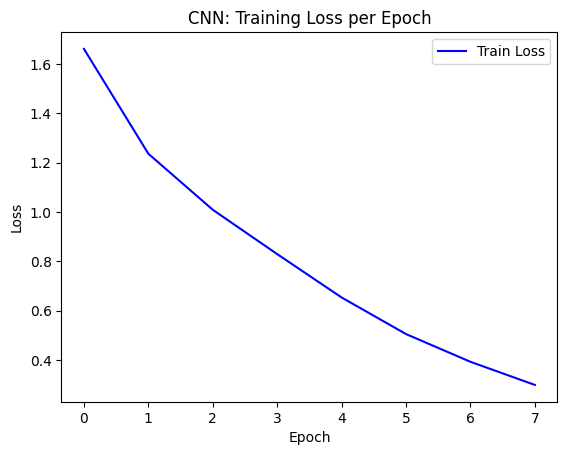

In [ ]:
# for batches per epoch
train_batches_per_epoch = len(train_loader)
val_batches_per_epoch = len(val_loader)

cnn_train_epoch_losses = [np.mean(cnn_model.cnn_train_losses[i:i+train_batches_per_epoch])
                      for i in range(0, len(cnn_model.cnn_train_losses), train_batches_per_epoch)]

cnn_val_epoch_losses = [np.mean(cnn_model.cnn_val_losses[i:i+val_batches_per_epoch])
                    for i in range(0, len(cnn_model.cnn_val_losses), val_batches_per_epoch)]

print("Epoch-wise Train Loss and Validation Loss:")
print("-" * 45)
print(f"{'Epoch':<10}{'Train Loss':<20}{'Val Loss'}")
print("-" * 45)
for epoch, (train_loss, val_loss) in enumerate(zip(cnn_train_epoch_losses, cnn_val_epoch_losses)):
    print(f"{epoch+1:<10}{train_loss:<20.4f}{val_loss:.4f}")

print("\n")

# Training Loss Plot
plt.plot(cnn_train_epoch_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN: Training Loss per Epoch')
plt.legend()
plt.show()

we can see the loss is decreasing every epoch and we get a accuracy of 65.6 %

##2. ResNet Model

**ResNet-18** here consists of *the final fully connected layer* was modified to fit the number of Imagenette dataset classes. Early stopping based on validation loss was again implemented to avoid overfitting and optimize training efficiency.

The model's performance was compared using **loss plots** for both training and validation phases, and its **accuracy** was tested on the test dataset.

In [ ]:
class ResNet18(pl.LightningModule):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.res_train_losses = []
        self.res_val_losses = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.res_train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.res_val_losses.append(loss.item())

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.002)

num_classes = len(full_dataset.classes)
res_model = ResNet18(num_classes=num_classes)

# Early Stopping Callback
early_stop_callback = EarlyStopping(monitor="val_loss",
    patience=3,          # Stop if val_loss doesn’t improve for 3 consecutive epochs
    mode="min",          # Minimize validation loss
    verbose=True
)

In [ ]:
# Trainer with Early Stopping
trainer = pl.Trainer(max_epochs=15,callbacks=[early_stop_callback])

# Train the model
trainer.fit(res_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNet             | 11.2 M | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 2.212


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.160 >= min_delta = 0.0. New best score: 1.052


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.255 >= min_delta = 0.0. New best score: 0.797


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.797. Signaling Trainer to stop.


We can see the best loss recorded by early stopping is 0.797.

In [ ]:
# Call the function to test accuracy
evaluate_model(res_model, test_loader)

Test Accuracy: 69.94%


69.9367088607595

With the accuracy of 69.9% we can see Resnet is performing better than CNN

Epoch-wise Train Loss and Validation Loss:
---------------------------------------------
Epoch     Train Loss          Val Loss
---------------------------------------------
1         1.3303              2.2575
2         0.9726              1.1338
3         0.7435              0.8243
4         0.6453              0.8725
5         0.5053              0.8178
6         0.3662              0.8681




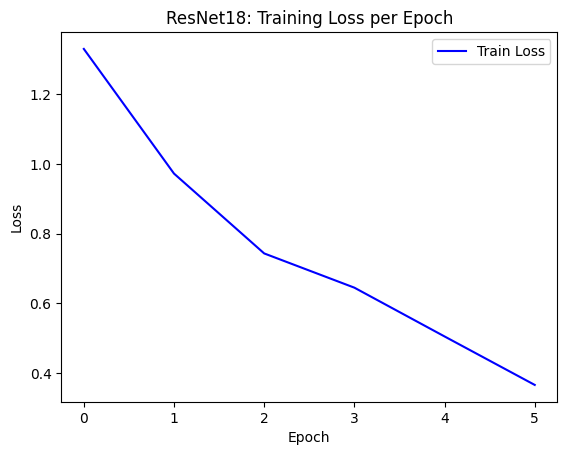

In [ ]:
res_train_epoch_losses = [np.mean(res_model.res_train_losses[i:i+train_batches_per_epoch])
                      for i in range(0, len(res_model.res_train_losses), train_batches_per_epoch)]

res_val_epoch_losses = [np.mean(res_model.res_val_losses[i:i+val_batches_per_epoch])
                    for i in range(0, len(res_model.res_val_losses), val_batches_per_epoch)]

print("Epoch-wise Train Loss and Validation Loss:")
print("-" * 45)
print(f"{'Epoch':<10}{'Train Loss':<20}{'Val Loss'}")
print("-" * 45)
for epoch, (train_loss, val_loss) in enumerate(zip(res_train_epoch_losses, res_val_epoch_losses)):
    print(f"{epoch+1:<10}{train_loss:<20.4f}{val_loss:.4f}")

print("\n")
# Training Loss Plot
plt.plot(res_train_epoch_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18: Training Loss per Epoch')
plt.legend()
plt.show()

Compare: CNN vs ResNet

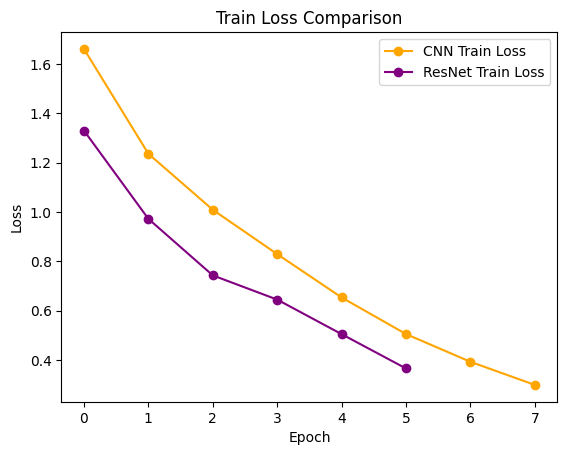

In [ ]:
# Plot Train Loss
plt.plot(cnn_train_epoch_losses, label='CNN Train Loss', color='orange', marker = 'o')
plt.plot(res_train_epoch_losses, label='ResNet Train Loss', color='purple', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

We can concluded based on the loss and accuracy that Resnet is better and moving ahead we can apply regularization to it in order to tune it even more.

##Regularization with Data Augmentation


To improve Resnet model, I used data augmentation here. The steps includes Random Horizontal Flip, Random Rotation, Random Crop, and Color Jitter during training.

The impact of these regularization methods was evaluated by comparing the test accuracy of ResNet-18 without augmentation and with augmentation. It showed better generalization ability and reduced overfitting.

In [ ]:
from torchvision import transforms

transform_train_reg = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),  # Reduced rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Lower intensity
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

full_dataset_reg = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'),
    transform=transform_train_reg
)

# Apply test transform to val/test
transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

early_stop_callback = EarlyStopping(
    monitor="val_loss",     # track val_loss
    patience=3,             # Wait 3 full epochs with no improvement
    min_delta=0.001,        # Small improvements still count
    mode="min",             # Lower val_loss is better
    verbose=True
)

In [ ]:
model_reg = ResNet18(num_classes=len(full_dataset.classes))

trainer_reg = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    callbacks=[early_stop_callback]
)

trainer_reg.fit(model_reg, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNet             | 11.2 M | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.658


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.727 >= min_delta = 0.001. New best score: 0.931


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.122 >= min_delta = 0.001. New best score: 0.808


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.808. Signaling Trainer to stop.


In [ ]:
evaluate_model(model_reg, test_loader)

Test Accuracy: 72.89%


72.8902953586498

Epoch-wise Train Loss and Validation Loss:
---------------------------------------------
Epoch     Train Loss          Val Loss
---------------------------------------------
1         1.4597              1.7498
2         0.9440              2.0064
3         0.8147              0.9923
4         0.5943              1.0599
5         0.4939              0.8227
6         0.4313              1.3384
7         0.2890              1.0649
8         0.2249              1.0054




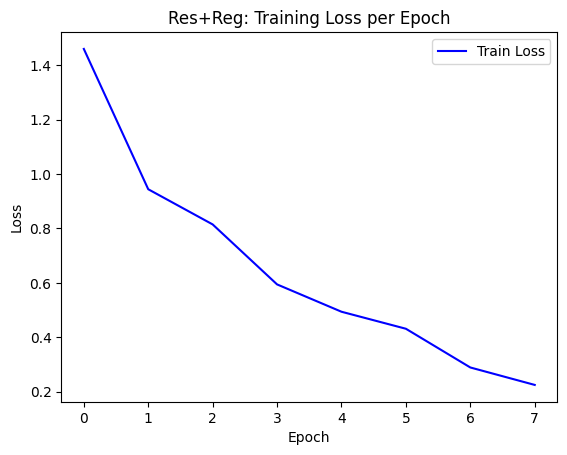

In [ ]:
reg_train_epoch_losses = [np.mean(model_reg.res_train_losses[i:i+train_batches_per_epoch])
                      for i in range(0, len(model_reg.res_train_losses), train_batches_per_epoch)]

reg_val_epoch_losses = [np.mean(model_reg.res_val_losses[i:i+val_batches_per_epoch])
                    for i in range(0, len(model_reg.res_val_losses), val_batches_per_epoch)]

print("Epoch-wise Train Loss and Validation Loss:")
print("-" * 45)
print(f"{'Epoch':<10}{'Train Loss':<20}{'Val Loss'}")
print("-" * 45)

for epoch, (train_loss, val_loss) in enumerate(zip(reg_train_epoch_losses, reg_val_epoch_losses)):
    print(f"{epoch+1:<10}{train_loss:<20.4f}{val_loss:.4f}")

print("\n")
# Training Loss Plot
plt.plot(reg_train_epoch_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Res+Reg: Training Loss per Epoch')
plt.legend()
plt.show()

The accuracy increased to 72.9%. Lets check the pre and post regularization results.



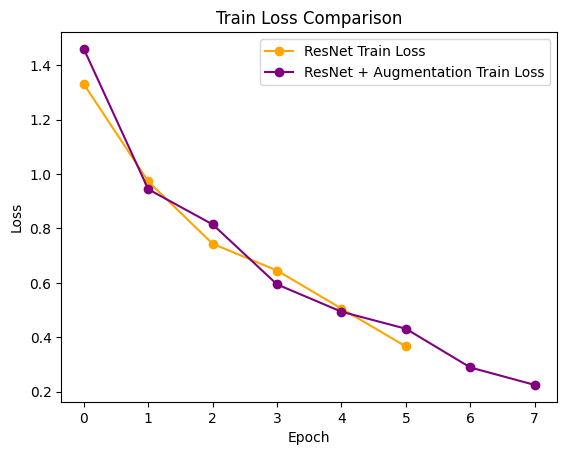

In [ ]:
plt.plot(res_train_epoch_losses, label='ResNet Train Loss', color='orange', marker = 'o')
plt.plot(reg_train_epoch_losses, label='ResNet + Augmentation Train Loss', color='purple', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

We can see how regularization has improved the resnet model and accuracy also increased to 73%

In [ ]:
# Save only weights
torch.save(model_reg.state_dict(), "model_reg_weights.pth")

##Transfer Learning: Using CIFAR10 dataset

Transfer learning was applied by reusing the regularized ResNet-18 model, which was pre-trained on the Imagenette dataset, and fine-tuning it on the CIFAR10 dataset.

This pre-trained model was compared with a ResNet-18 trained from scratch on CIFAR10. The transfer learning model showed faster convergence and improved accuracy due to the knowledge transferred from the previous dataset.

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transforms for CIFAR10
transform_train_cifar = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_test_cifar = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Load CIFAR10
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_cifar)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test_cifar)

# Split CIFAR10 train into train & val
train_size = int(0.8 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
cifar10_train, cifar10_val = random_split(cifar10_train, [train_size, val_size])

train_loader_cifar = DataLoader(cifar10_train, batch_size=32, shuffle=True)
val_loader_cifar = DataLoader(cifar10_val, batch_size=32, shuffle=False)
test_loader_cifar = DataLoader(cifar10_test, batch_size=32, shuffle=False)


In [ ]:
model_reg = ResNet18(num_classes=len(full_dataset.classes))
model_reg.load_state_dict(torch.load("model_reg_weights.pth"))

 # Updating classifier head for CIFAR10 (10 classes)
model_reg.model.fc = torch.nn.Linear(model_reg.model.fc.in_features, 10)

# EarlyStopping for Transfer Learning
early_stop_C10 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    min_delta=0.001,
    mode="min",
    verbose=True
)

# Fine-tune on CIFAR10
trainer_C10 = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    callbacks=[early_stop_C10]
)

# Train on CIFAR10 dataset
trainer_C10.fit(model_reg, train_loader_cifar, val_loader_cifar)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNet             | 11.2 M | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.764


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.144 >= min_delta = 0.001. New best score: 0.619


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.598


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.001. New best score: 0.551


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.522


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.515


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.513


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.489


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.489. Signaling Trainer to stop.


In [ ]:
evaluate_model(model_reg, test_loader_cifar)

Test Accuracy: 83.68%


83.68

Epoch-wise Train Loss and Validation Loss:
---------------------------------------------
Epoch     Train Loss          Val Loss
---------------------------------------------
1         1.0090              0.7744
2         0.6833              0.6200
3         0.5494              0.5969
4         0.4574              0.5517
5         0.3900              0.5216
6         0.3337              0.5138
7         0.2805              0.5135
8         0.2407              0.4879
9         0.2097              0.5025
10        0.1836              0.5206
11        0.1563              0.5379




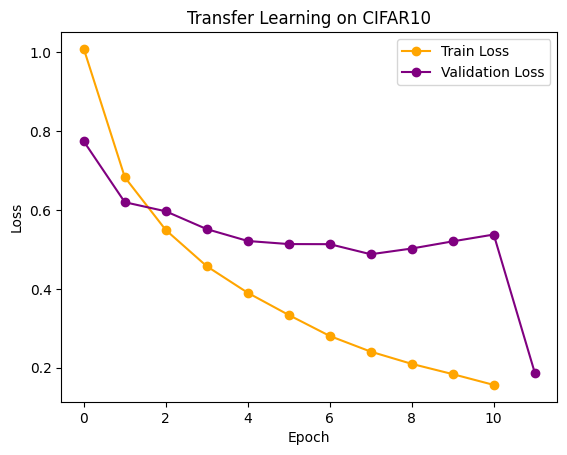

In [ ]:
# Plot Loss
train_batches_per_epoch = len(train_loader_cifar)
val_batches_per_epoch = len(val_loader_cifar)

C10_train_epoch_losses = [np.mean(model_reg.res_train_losses[i:i+train_batches_per_epoch])
                         for i in range(0, len(model_reg.res_train_losses), train_batches_per_epoch)]

C10_val_epoch_losses = [np.mean(model_reg.res_val_losses[i:i+val_batches_per_epoch])
                       for i in range(0, len(model_reg.res_val_losses), val_batches_per_epoch)]

print("Epoch-wise Train Loss and Validation Loss:")
print("-" * 45)
print(f"{'Epoch':<10}{'Train Loss':<20}{'Val Loss'}")
print("-" * 45)
for epoch in range(min(len(C10_train_epoch_losses), len(C10_val_epoch_losses))):
    print(f"{epoch+1:<10}{C10_train_epoch_losses[epoch]:<20.4f}{C10_val_epoch_losses[epoch]:.4f}")


print("\n")

plt.plot(C10_train_epoch_losses, label='Train Loss', color='orange', marker = 'o')
plt.plot(C10_val_epoch_losses, label='Validation Loss', color='purple', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transfer Learning on CIFAR10')
plt.legend()
plt.show()

 Training and validation loss plots are decreasing showing better performance. With 83% accuracy we can see that our model is giving good results.